# 01 - Take samples

In this notebook we will read the json files provided in the **Retail Product Checkout Dataset** and create dataframes for easily accessing the necessary information in the future.

For this project we will ignoe the images in the training sample as they do not fit the project objective. Therefore, whatever is listed as validation will be used as train/validation while the test remains its purpose.

Finally, each image information is listed in the COCO format. More details will be provided as we work on the files.

## Imports and reading the files

In [1]:
import pandas as pd
import numpy as np
import json
import imageio
import matplotlib.pyplot as plt

from funcs.plot import show_image

In [2]:
plt.rcParams['figure.figsize'] = (12,8)

For the project, the json files holds two important informations in these keys:

* annotations: For each unique image id, contains the bounding box parameters for each object in the image as well as other pertinent information. The annotations follow the COCO format, which mean that any bounding box follows [x, y, width, height]

* images: Contains general information about the image, such as its file name, unique id, width and height 


To extract these keys, we first read the json files and pass through a function to transform into Pandas dataframes

In [3]:
with open('data/retail_product/instances_val2019.json') as f:
    val_instances_dict = json.load(f)

with open('data/retail_product/instances_test2019.json') as f:
    test_instances_dict = json.load(f)

In [4]:
validation_images = pd.DataFrame(val_instances_dict['images'])
validation_images['file_name'] = 'data/retail_product/val2019/' + validation_images['file_name'] # Computing the full image path
validation_annotations = pd.DataFrame(val_instances_dict['annotations'])

test_images = pd.DataFrame(val_instances_dict['images'])
# We have a test folder with images, but the labels are not provided. So, the test annotations given are from a subset of the images found on the validation folder
test_images['file_name'] = 'data/retail_product/val2019/' + test_images['file_name']

test_annotations = pd.DataFrame(val_instances_dict['annotations'])

In [5]:
validation_images.head()

,file_name,width,height,id,level
0,data/retail_product/val2019/20180827-16-07-06-...,1850,1850,220,easy
1,data/retail_product/val2019/20180827-16-07-10-...,1840,1840,221,easy
2,data/retail_product/val2019/20180827-16-24-37-...,1826,1826,222,easy
3,data/retail_product/val2019/20180827-16-24-44-...,1829,1829,223,easy
4,data/retail_product/val2019/20180827-16-24-53-...,1826,1826,224,easy


In [6]:
validation_annotations.head()

,area,bbox,category_id,id,image_id,iscrowd,segmentation,point_xy
0,145968.80,"[519.44, 965.19, 405.05, 360.37]",96,751,220,0,[[]],"[721.97, 1145.38]"
1,96655.05,"[282.17, 962.21, 278.97, 346.48]",111,752,220,0,[[]],"[421.66, 1135.45]"
2,85148.42,"[477.74, 1181.62, 236.28, 360.37]",87,753,220,0,[[]],"[595.88, 1361.8]"
3,87298.95,"[726.93, 1245.15, 343.5, 254.15]",87,754,220,0,[[]],"[898.68, 1372.23]"
4,60313.52,"[1223.01, 286.82, 171.8, 351.07]",87,755,221,0,[[]],"[1308.91, 462.36]"


As an example let's show one image

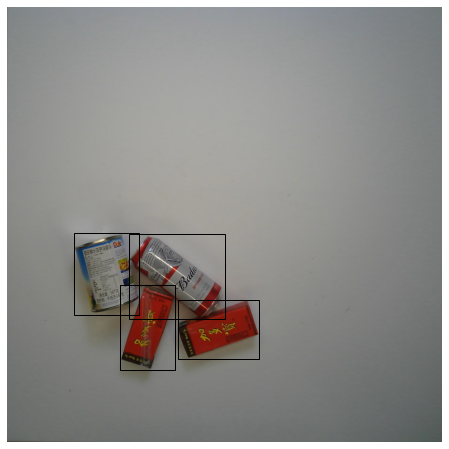

In [7]:
show_image(220, validation_images, validation_annotations)

plt.show()

## Taking a random sample

One of the scopes of this work is to apply outlier detection to patches of an image to estimate if that patch contains an object. The **Retail Product Checkout Dataset** is quite sizeful in which the validation and test together have 12,000 images

In [8]:
validation_images.shape[0] + test_images.shape[0]

12000

The images are also fairly large and with a fair amount of pixels, with the average image having 3,352,015 pixels

In [9]:
validation_images['n_pixels'] = validation_images['width']*validation_images['height']
test_images['n_pixels'] = test_images['width']*test_images['height']

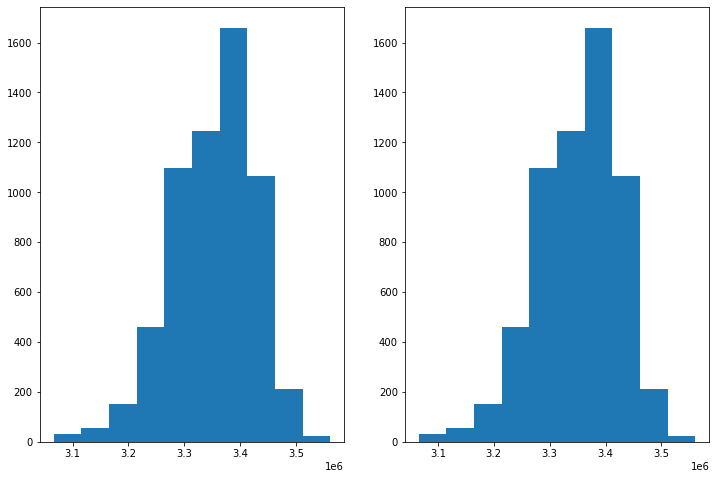

In [10]:
fig, axs = plt.subplots(ncols=2)


for df, ax in zip([validation_images, test_images], axs):
    ax.hist(df['n_pixels'])

plt.show()

However, they are all square, having the same height and width

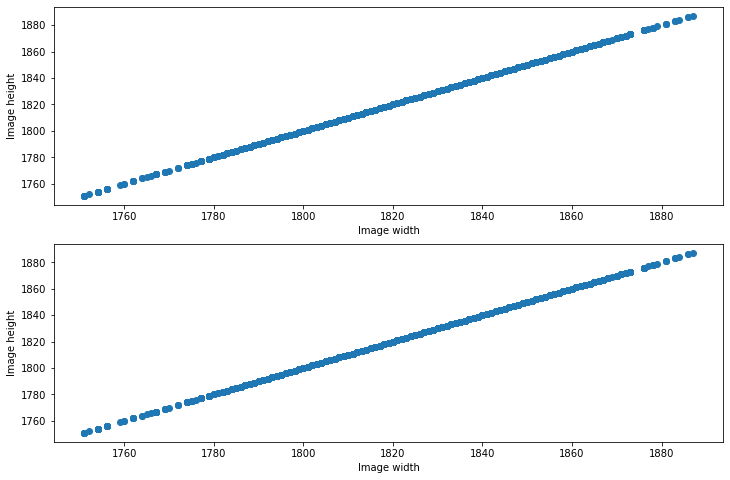

In [11]:
fig, axs = plt.subplots(nrows=2)


for df, ax in zip([validation_images, test_images], axs):
    ax.scatter(df['width'], df['height'])
    ax.set_xlabel('Image width')
    ax.set_ylabel('Image height')

plt.show()

In [12]:
validation_images[['width', 'height', 'n_pixels']].describe()

,width,height,n_pixels
count,6000.000000,6000.000000,6.000000e+03
mean,1830.739333,1830.739333,3.352015e+06
std,20.213176,20.213176,7.378836e+04
min,1751.000000,1751.000000,3.066001e+06
25%,1817.000000,1817.000000,3.301489e+06
50%,1833.000000,1833.000000,3.359889e+06
75%,1846.000000,1846.000000,3.407716e+06
max,1887.000000,1887.000000,3.560769e+06


In [13]:
test_images[['width', 'height', 'n_pixels']].describe()

,width,height,n_pixels
count,6000.000000,6000.000000,6.000000e+03
mean,1830.739333,1830.739333,3.352015e+06
std,20.213176,20.213176,7.378836e+04
min,1751.000000,1751.000000,3.066001e+06
25%,1817.000000,1817.000000,3.301489e+06
50%,1833.000000,1833.000000,3.359889e+06
75%,1846.000000,1846.000000,3.407716e+06
max,1887.000000,1887.000000,3.560769e+06


Hence, depending on the size of each patch, it would be quite easy to end up with a fairly sizable set of patches, and consequently, a quite lofty amount of data to process.

Therefore, for starters we will take 40 random samples. 30 from validation where 20 will be for training and 10 for validation. The remaining 10 will come from the test dataset and will be used as a true out-of-sample to evaluate the final performance of the task.

As we saw, the number of images differ for the test set. Therefore, some images might not be in the dataframe, while other images might be in the dataframe, but not in the folder. So, for taking the sample for test, we will take a large sample as test if the file exists. If it does, we will keep in the dataframe and prune de size of it later.

In [16]:
validation_images_sample = validation_images.sample(n=30, replace=False, random_state=1).reset_index(drop=True)
test_images_sample = test_images.sample(n=10, replace=False, random_state=1).reset_index(drop=True)

validation_images_sample['source'] = np.where(np.array(validation_images_sample.index) < 20, 'train', 'validation')
test_images_sample['source'] = 'test'


validation_annotations_sample = validation_annotations.loc[validation_annotations['image_id'].isin(validation_images_sample['id'])]
test_annotations_sample = test_annotations.loc[test_annotations['image_id'].isin(test_images_sample['id'])]

In [17]:
validation_images_sample['source'].value_counts()

train         20
validation    10
Name: source, dtype: int64

In [18]:
validation_annotations_sample['image_id'].unique().shape

(30,)

In [19]:
test_annotations_sample['image_id'].unique().shape

(10,)

Let's save the dataframes to use later

In [20]:
validation_images_sample.to_pickle('data/retail_product/train_val_images.pkl')
validation_annotations_sample.to_pickle('data/retail_product/train_val_annotations.pkl')

test_images_sample.to_pickle('data/retail_product/test_images.pkl')
test_annotations_sample.to_pickle('data/retail_product/test_annotations.pkl')

In [105]:
import imageio
from sklearn.feature_extraction.image import extract_patches_2d
from skimage.transform import resize
from skimage.util import view_as_blocks

In [50]:
validation_images_sample.iloc[0, 0]

'data/retail_product/val2019/20180831-13-59-15-2191.jpg'

In [51]:
img = imageio.imread('data/retail_product/val2019/20180831-13-59-15-2191.jpg')

In [127]:
img.shape

(1802, 1802, 3)

In [139]:
(1802**2)/(200**2)

2435.403

In [94]:
resized_img = resize(img, (512, 512), preserve_range=True).astype(np.uint8)

In [59]:
extract_patches_2d(img, (20, 20)).shape

(3179089, 20, 20, 3)

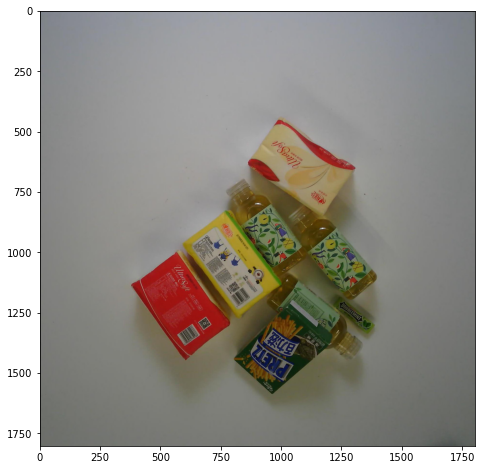

In [95]:
plt.imshow(img)

In [85]:
resized_img.min()*255

0.025478515510193023

In [84]:
resized_img.max()*255

221.00373889848996

In [124]:
(512**2)/(64**2)

64.0

In [138]:
(1024**2)/(64**2)

256.0

In [142]:
block_img = view_as_blocks(resized_img, (64, 64, 3))

In [131]:
view_as_blocks(img, (200, 200, 3)).shape

ValueError: 'block_shape' is not compatible with 'arr_in'

In [143]:
block_img.shape

(8, 8, 1, 64, 64, 3)

In [144]:
block_img = block_img.reshape(-1, 64, 64, 3)

In [145]:
block_img.shape

(64, 64, 64, 3)

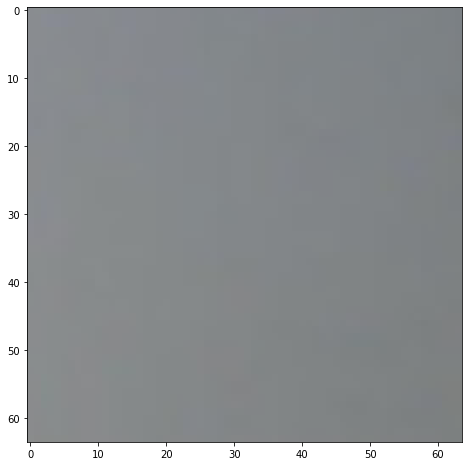

In [151]:
plt.imshow(block_img[15, :, :, :])

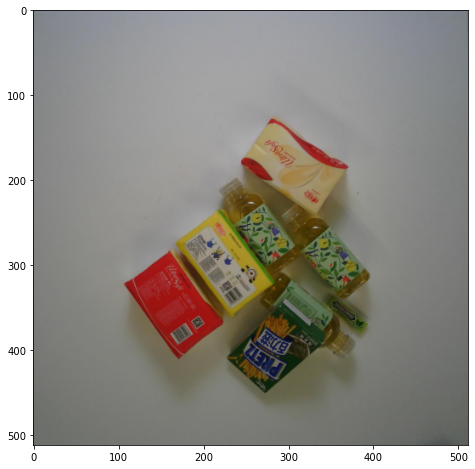

In [96]:
plt.imshow(resized_img)